In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Aim
This notebook aims at better understanding the paper from Yang and Chan [PDA J Pharm Sci and Tech 2013, 67 601-609](http://journal.pda.org/lookup/doi/10.5731/pdajpst.2013.00942) and re-implement their approach in Python.

# Background

The abstract from the paper describes quite nicely the new risk based approach for testing bioburden fitrations as suggested by EMA:

>Microbial control during the drug substance and drug product manufacturing process is critical for ensuring product quality and safety. For sterile biological drug products (finished dosage forms) typically manufactured by sterile filtration followed by aseptic processing, control of the microbial load at the sterile filtration step is an important component of the overall microbial control strategy. Both FDA and EMA regulatory guidelines stipulate that a maximum acceptable bioburden level, which is referred to as a pre-filtration bioburden level in this paper, should be stated at the point immediately prior to the sterile filtration step. The EMA guideline further states that a bioburden limit of no more than 10 colony-forming units (CFU) per 100 mL will be considered acceptable in most situations. The EMA guideline also states that a pre-filtration sample volume of less than 100 mL may be tested if justified. This paper introduces a risk-based method to establish pre-filtration bioburden acceptance levels and alternative test volumes. The relationship between bioburden risk, pre-filtration bioburden test limits, and sterile filtration process parameters, such as filtration volume, filter surface area, and microbial retention capacity of the sterilizing filter, was statistically determined. Taking into account the batch filtration volume, it is shown that pre-filtration bioburden test volumes and acceptance limits other than 10 CFU/100 mL may be justified, without compromise to sterility assurance. [Yang and Chan](http://journal.pda.org/lookup/doi/10.5731/pdajpst.2013.0094


## Negative binomial distribution

Bioburden levels are often described as Poisson distribution. As [Yang](https://www.taylorfrancis.com/books/edit/10.1201/9781315180212/bayesian-methods-pharmaceutical-research-emmanuel-lesaffre-gianluca-baio-bruno-boulanger) states in Chpt. 11.5.2, a Poisson distribution requires bacteria to be distributed uniformly throughout the bulk volume. However, bacteria might form clumps and observed variability is often larger than expected based on a Poisson distribution (a phenomena called overdispersion). A more suitable distribution is the negative Binomial distribution.

To illustrate the chosen distribution, following scenario is considered:

- The true CFU count of a solution is 11 CFU / 100 mL
- The assay variability is twice that of the mean which resembles to a standard deviation of 4.7 CFU/100 mL in this case
- The upper acceptance limit is 10 CFU / 100 mL

Following the paper, a negative binomial distribution is assumed for the data. Scipy`s implementation of the distribution requires reformulation of the parameters as described in the [online documenation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html) and shown below:

In [41]:
# the (assumed) true mean
mu = 11 # CFU/100mL

# the variation of the assay
var = 2*mu

# the upper accepance limit
ual = 10  # upper acceptance limit'

# the negative binomial distribution 
p = mu / var
n = mu * p / (1-p)

# the negative binomial distribution
nb = stats.nbinom(n=n, p=p)

# for comparison the poisson distribution
pois = stats.poisson(mu=mu)

The figure below shows the Negative Binomial distribution in comparison with the Poisson distribution. It is quite obvious that the Poisson distribution yields a more narrow range of expected CFU counts per 100 mL.

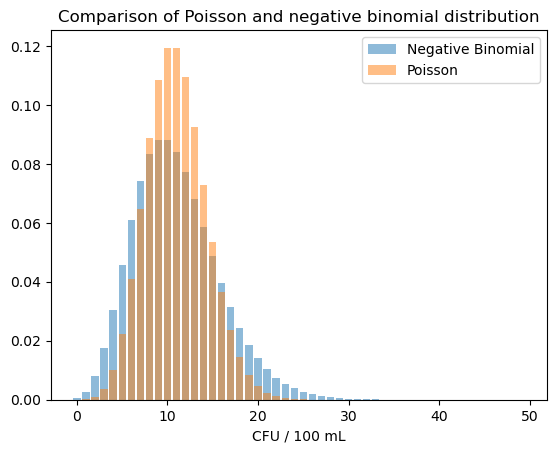

In [42]:
xhat = np.arange(0,50)
plt.bar(xhat, nb.pmf(xhat), alpha=0.5, label='Negative Binomial')
plt.bar(xhat, pois.pmf(xhat), alpha=0.5, label='Poisson')
plt.title('Comparison of Poisson and negative binomial distribution')
plt.legend(loc=1)
_ = plt.xlabel('CFU / 100 mL')

The (assumed) underlying Negative Binomial distribution describes the most probable results (measured CFU counts) if exactly the same experiment is repeated indefinetly. The figure below answers following questions:

- What is the probability of overving a certain CFU count (blue and orange bars)
- What is the probability of observing a CFU count below the upper acceptance limit (UAL) (blue line)?
- What is the probability of observing a CFU count above the upper acceptance limit (UAL) (orange line).

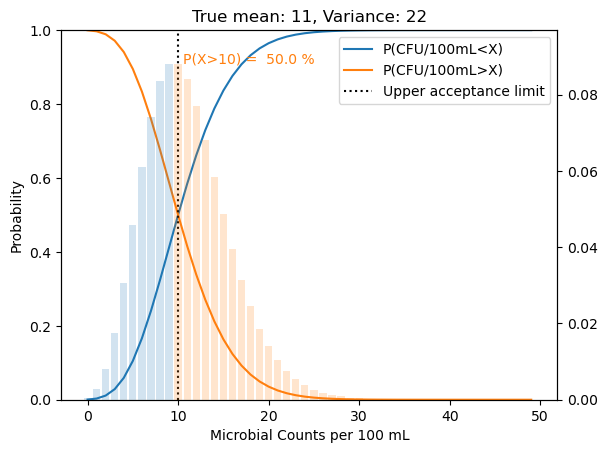

In [40]:
# CFU/100 mL on the x axis
xhat = np.arange(0,50)

# the probability of observing values below xhat for the given distribution
yhat = nb.cdf(xhat)

# the probability of observing values above xhat for the given distribution
yhat1 = nb.sf(xhat)

# the probability mass function
y_pmf = nb.pmf(xhat)

x0 = xhat[xhat<ual]
x1 = xhat[xhat>=ual]
y_pmf_0 = nb.pmf(x0)
y_pmf_1  = nb.pmf(x1)

fig, ax = plt.subplots(ncols=1)
ax1 = ax.twinx()

ax.plot(xhat, yhat, label='P(CFU/100mL<X)')
ax.plot(xhat, yhat1, label='P(CFU/100mL>X)')

ax1.bar(x0, y_pmf_0, alpha=0.2)
ax1.bar(x1, y_pmf_1, alpha=0.2)
ax.vlines(ymin=0, ymax=1, x=ual, color='black', linestyle=':', label='Upper acceptance limit')

plt.text(x=ual*1.05, y=max(y_pmf_0), 
         s=f'P(X>{ual:0.0f}) =  {nb.sf(ual)*100:0.1f} %', 
         color='C1')

ax1.set_ylim(0, max(y_pmf_0)*1.1)
ax.set_ylim(0, 1)

ax.legend(loc='best')
_ = ax.set_xlabel('Microbial Counts per 100 mL')
_ = ax.set_ylabel('Probability')
_ = ax.set_title(f'True mean: {mu}, Variance: {var}')

## Performance of prefiltration test procedure

Yang et al. provide the performance characteristics of a prefiltration test in Figure 1. The figure below reproduces Figure 1 from the paper under following scenario:

- The assay variability depends on the measured CFU count and is twice the mean.
- The x-axis describes the true CFU count per 100 mL.
- Given the measured CFU count and the assumed assay variability, how probable is it that the actual CFU count per 100 mL is actually below the UAL of 10?

For an true CFU count of 9 CFU / 100 mL the probability of correctly accepting the batch is about 68 %.
For an true CFU count of 11 CFU / 100 mL the probability of correctly rejecting the batch is about 50 %.

According to Yang et al.:

> The results suggest that the EMA-recommended acceptance limits provide protection to neither the consumer`s risk nor the producers risk



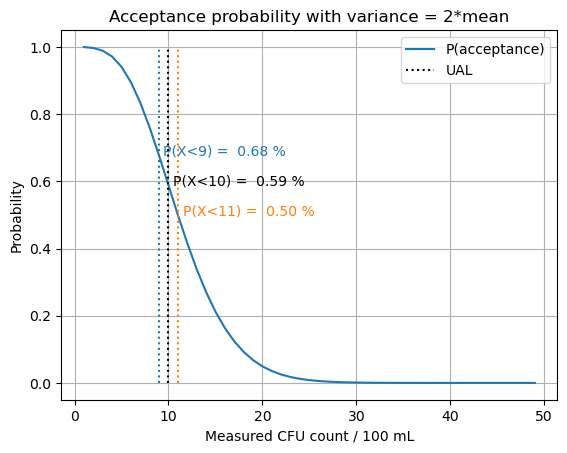

In [70]:
"""
This plot resembles figure 1
"""

# plot the probability of acceptance for various means
cfu_observed = np.arange(1,50)  # CFU/100mL
p_acc_list = []
for mu in cfu_observed:
    
    var = 2*mu  # variability is twice the mean
    ual = 10  # upper acceptance limit'
    # refactoring to match scipy`s parametrization for the negative binomial distribution
    p = mu / var
    n = mu * p / (1-p)

    # calculation of the acceptance rate (probability of X < UAL)
    nb = stats.nbinom(n=n, p=p)
    p_acc_list.append(nb.cdf(ual))

# the performance curve
plt.plot(cfu_observed, p_acc_list, label='P(acceptance)')
# the UAL
plt.vlines(x=ual, ymin=0, ymax=1, linestyle=':', color='k', label='UAL')
# acceptance probability at 10 CFU / 100 mL
plt.text(x=ual*1.05, y=p_acc_list[np.where(cfu_observed == 10)[0][0]], 
         s=f'P(X<{ual:0.0f}) =  {p_acc_list[np.where(cfu_observed == 10)[0][0]]:0.2f} %', 
         color='black')

def plot_hline(xtest, color='gray'):
    plt.vlines(x=xtest, ymin=0, ymax=1, linestyle=':', color=color)
    # acceptance probability at 10 CFU / 100 mL
    plt.text(x=xtest*1.05, y=p_acc_list[np.where(cfu_observed == xtest)[0][0]], 
            s=f'P(X<{xtest:0.0f}) =  {p_acc_list[np.where(cfu_observed == xtest)[0][0]]:0.2f} %', 
            color=color)

plot_hline(9, color='C0')
plot_hline(11, color='C1')

plt.grid(visible=True, which="both")
plt.title('Acceptance probability with variance = 2*mean')
plt.ylabel('Probability')
plt.xlabel('True CFU count / 100 mL')
plt.legend(loc=1)

# Figure 2

Figure 2 in the paper shows the performance characteristic of the test for various sample sizes. Obviously, this is an important measure since it would be desirable to use smaller sample volumes than 100 mL.

The figure can be reproduced using the code shown below. Following scenarios are assumed:


- Varying sample sizes of 10, 30 and 100 mL
- The x-axis shows the assumed true microbial counts (depicted as D in the legends) as CFU per 100 mL
- The y-axis shows the probabilty that the batch is accepted based on the given UAL and true CFU per 100 mL

At a true CFU count of exactly the UAL (10 CFU / 100 mL), the lower sample volume leads to a higher chance of accepting the batch (75%) compared to a sample volume of 100 mL with an acceptance rate of 58.8 %.

Text(0, 0.5, 'Probability of acceptance')

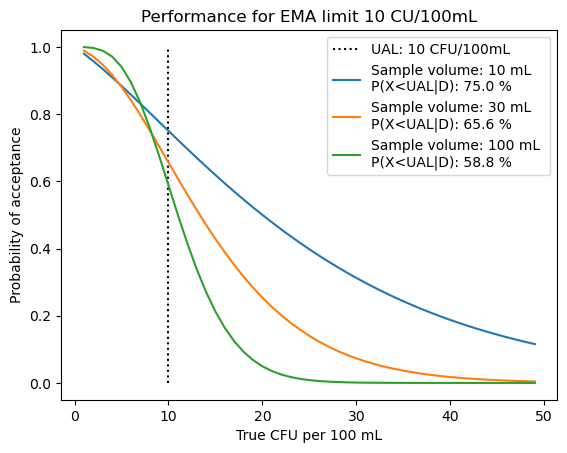

In [109]:
volumes = np.array([10, 30, 100])  # mL
ual_100mL = 10
ual = volumes / 100 * ual_100mL  # CFU/100mL
xhat = np.arange(1,50)  # CFU/100mL
true_mu = 10  # CFU/100mL
var = 2*true_mu

fig, ax = plt.subplots(ncols=1)

ax.vlines(ymin=0, 
            ymax=1, 
            x=ual_100mL, 
            color='k', 
            linestyle=':' , 
            label=f"UAL: {ual_100mL} CFU/100mL")

for i, vol in enumerate(volumes):
    p_acc_list = []
    for mu in xhat:
        # adjusting the bioburden count from CFU/100mL tothe actual volume
        mu = mu * vol / 100 
        var = 2*mu
        # reparameterize to match scipy's nb function
        p = mu / var
        n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
        nb = stats.nbinom(n=n, p=p)
        p_acc_list.append(nb.cdf(ual[i]))
    
    # the probability of accepting the batch if CFU counts are exactly 10 / 100 mL
    p_acc_ual = p_acc_list[np.where(xhat == ual_100mL)[0][0]]   
    ax.plot(xhat, p_acc_list, label=f'Sample volume: {vol} mL \nP(X<UAL|D): {p_acc_ual*100:0.1f} %', color=plt.cm.tab10(i))


ax.legend(loc=1)
ax.set_title('Performance for EMA limit 10 CU/100mL')
ax.set_xlabel('True CFU per 100 mL')
ax.set_ylabel('Probability of acceptance')

The figure below is an alternative representation of Figure 2 from the paper. It tries to resemble Figure 7.6 from the book [Statistics for Biotechnology Process Development](https://www.taylorfrancis.com/books/edit/10.1201/9781315120034/statistics-biotechnology-process-development-todd-coffey-harry-yang)

The figure answers following question:

- Given a true microbial count of 10 CFU / 100 mL, what count could be proven at 95 % confidence for different sample sizes?

Text(0.5, 1.0, 'True mean: 10 CFU/100mL, Variance=2*mean')

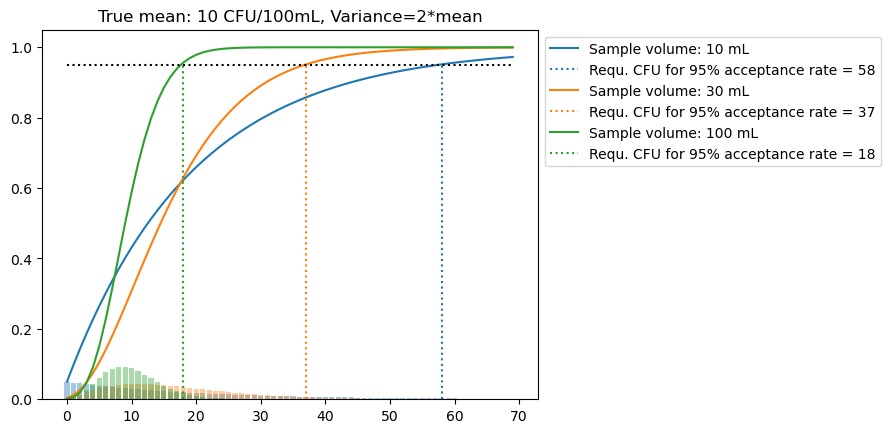

In [78]:
"""
This figure is an alternative representation to those from the paper. 
It tries to resemble Figure 7.6 from the Book "Emerging Non-Clinical Biostatistics in Biopharmaceutical Development and Manufacturing"
However, the probabilities are not the same. The book yields 63, 32, 20 CFUs for 95% detection probability.
I am not sure, if adapting p is the proper choice.
"""
volumes = np.array([10, 30, 100])  # mL
ual_100_ml = 10  # CFU per 100 ml

# conversion of the acceptance limit to the actual sample volume
ual = volumes / ual_100_ml  # MCU/100mL

mu = 10
var = 2*mu
# reparameterize to match scipy's nb function
p = mu / var
n = mu**2 / (var - mu)  # equivalent to n = mu * p / (1-p)
    
fix, ax = plt.subplots(ncols=1)
xhat = np.arange(0,70)
#xhat = np.linspace(0, 70, 100)

for i, vol in enumerate(volumes):
    p_adj = p*vol/100
    nb = stats.nbinom(n=ual[i], p=p_adj)
    ax.plot(xhat, nb.cdf(xhat), label=f'Sample volume: {vol} mL', color=plt.cm.tab10(i))
    #ax.plot(xhat, nb.sf(xhat), color=plt.cm.tab10(i), linestyle='--', label=f'sample volume: {volumes[i]}')
    ax.vlines(ymin=0, 
              ymax=nb.cdf(nb.ppf(0.95)), 
              x=nb.ppf(0.95), 
              color=plt.cm.tab10(i), 
              linestyle=':' , 
              label=f'Requ. CFU for 95% acceptance rate = {nb.ppf(0.95):0.0f}')
    ax.bar(xhat, nb.pmf(xhat), alpha=0.4)

ax.hlines(xmin=xhat[0], xmax=xhat[-1], y=0.95, linestyle=':', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title(f'True mean: 10 CFU/100mL, Variance=2*mean')